In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

from utils import *

In [ ]:
# Relative path to  logfile
logfile="00000247.log"

# List of sensor names to retain
# theres a LOT of sensors I'm not using
keys=["IMU","IMU2","IMU3","MAG2","MAG3"]

#Read in the logdata only for the inertial sensors
data_dict=parse_arducopter_log(logfile,keys=keys)

for key in keys:
    print(key, len(data_dict[key]))

In [ ]:
data_dict["IMU"]

In [ ]:
## Format the sensor data for my wrappers to the pose-estimation api
IMU=data_dict["IMU3"]
gyro= np.array([IMU['GyrX'],IMU['GyrY'],IMU['GyrZ']],dtype=np.float).T
acc=np.array([IMU['AccX'],IMU['AccY'],IMU['AccZ']],dtype=np.float).T
mag=np.zeros(np.shape(acc))
ts=np.array(IMU['TimeUS'],dtype=np.float)/1e6
#Ts=np.array(IMU['T'],dtype=np.float)


mask= (115<ts) & (ts<130)

plt.plot(ts[mask],acc[mask,0],color='r')
plt.plot(ts[mask],acc[mask,1],color='g')
## Shift the z axis so the scales are better
plt.plot(ts[mask],acc[mask,2]+9.899,color='b')

In [4]:

##Use a hand-picked quiet value to determine the gravity estimate 
#246.log
#mask= (25<ts) & (ts<110)
#247.log
mask= (115<ts) & (ts<130)

g=np.array([0,0,1])*np.linalg.norm(np.mean(acc[mask,:],axis=0))
##Run the ahrs w/o zeroing out the postion
acc_lab,Q,state,state_sampled,t_sampled=apply_ahrs(gyro,acc,mag,ts,g=g,position=True,zero_period=0.4)
t_sampled=np.array(t_sampled)
state_sampled=np.array(state_sampled)

<ipython-input-42-b6b8e7f40732>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


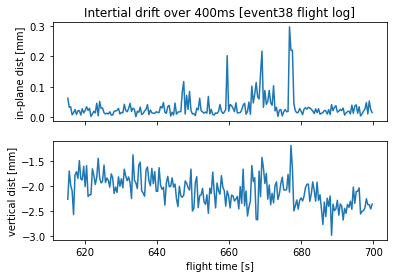

In [42]:

mask= (615<t_sampled) & (t_sampled<700)
#plt.plot(t_sampled[mask],state_sampled[mask,0:3])
#plt.show()
x,y,z=state_sampled[:,0],state_sampled[:,1],state_sampled[:,2]
in_plane=np.sqrt(x**2+y**2)


f, (ax1,ax2)=plt.subplots(2,1,sharex=True)
ax1.set_title('Intertial drift over 400ms [event38 flight log]')
ax1.plot(t_sampled[mask],in_plane[mask]*1e3)
ax1.set_ylabel('in-plane dist [mm]')
ax2.plot(t_sampled[mask],z[mask]*1e3)
ax2.set_ylabel('vertical dist [mm]')
ax2.set_xlabel('flight time [s]')

#plt.plot(t_sampled[mask],z[mask])
f.show()

In [46]:
Q[:,3]

array([ 3.72182459e-06,  6.97755926e-06,  9.41002953e-06, ...,
       -4.82732142e-03, -5.04162527e-03, -5.04162527e-03])

In [ ]:
def test_ahrs():
    ## Synthesize sensor data for a uniform acceleration of 1 m/s^2
    #inertial frame
    g=[0,0,0]

    sample_rate=1e4 #[Hz]
    t=1 #[s]
    ts=np.linspace(0,t,1+int(t*sample_rate))
    num_samples=len(ts)

    gyro=np.zeros((num_samples,3))
    acc= np.ones((num_samples,3))
    mag= np.zeros((num_samples,3))
    
    acc_lab,Q,state=apply_ahrs(gyro,acc,mag,ts,g=g,position=True,zero_period=30)
    
    plt.plot(Q)
    plt.show()
    
    #analytic solution
    # x_i(t) = 1/2 a_i t^2
    anal = 1/2*np.outer((ts**2),[1,1,1])
    return state[:,0:3]-anal

In [ ]:
zero=np.zeros((1001,3))
one=np.ones((1001,3))
ts=np.linspace(0,1,1001)
acc_lab,Q=apply_ahrs(zero,one,zero,ts,g=[0,0,0],position=False,zero_period=30)
plt.plot(Q)

In [ ]:
madgwick=ahrs.filters.Madgwick(beta=0.05,frequency=1000)
q0=Quaternion.q
Q=np.tile(q0,(1000,1))
for t in range(1,1000):
    Q[t]=madgwick.updateIMU(Q[t-1],[0,0,0],[1,1,1])
plt.plot(Q)

In [ ]:
Q[]

In [ ]:
data=ahrs.utils.io.Data()
data.acc=np.ones((4000,3))
data.gyr=np.zeros((4000,3))
data.mag=np.ones((4000,3))
data.num_samples=4000

madgwick=ahrs.filters.AQUA(beta=0.5,frequency=1000)
madgwick.input=dat
Q=madgwick.estimate_all()

In [ ]:
t=0
Q = np.tile([1., 0., 0., 0.], (data.num_samples, 1))
Q[0]

In [ ]:
Q

In [ ]:
Quaternion.q